## Gemoetry

In [114]:
import numpy as np
from math import sqrt, acos, atan2, pi, floor

# Geometric center of a polygon
def center(vertices):
    n = len(vertices)
    sumX = sumY = 0

    # Sum the vectors
    for x, y in vertices:
        sumX += x
        sumY += y

    # Divide by the number of sides
    cx = sumX / n
    cy = sumY / n

    return cx, cy


# Area of a polygon
def area(vertices):
    edges = zip(vertices, vertices[1:] + [vertices[0]])
    cross_product = sum((x0 * y1 - x1 * y0) for (x0, y0), (x1, y1) in edges)
    return 0.5 * abs(cross_product)


# Perimeter of a polygon
def perimeter(vertices):
    n = len(vertices)
    perimeter = 0

    for i in range(n):
        x0, y0 = vertices[i]
        x1, y1 = vertices[0] if i == n - 1 else vertices[i + 1]
        dist = euclidean_distance(x0, y0, x1, y1)
        perimeter += dist

    return perimeter


# Euclidean distance between (x, y) coordinates
def euclidean_distance(x0, y0, x1, y1):
    return sqrt((x0 - x1) ** 2 + (y0 - y1) ** 2)


# Difference with respect to periodic boundaries
def periodic_diff(v1, v2, L):
    return ((v1 - v2 + L / 2.) % L) - L / 2.


# Unit vector
def unit_vector(v1, v2):
    vector = v1 - v2
    dist = euclidean_distance(v1[0], v1[1], v2[0], v2[1])
    uv = vector / dist
    return uv


# Assumes 2D
def magnitude(v):
    return sqrt(v[0] ** 2 + v[1] ** 2)


# Generate a random angle theta
def rand_angle():
    # Generate a random number between -pi and pi
    theta = np.random.uniform(-pi, pi)
    return theta


# Returns a unit vector
def angle_2_vector(theta):
    x = np.cos(theta)
    y = np.sin(theta)

    # Transform to a unit vector
    v1 = np.array([x, y])
    v2 = np.array([0, 0])
    uv = unit_vector(v1, v2)

    return uv


def vector_2_angle(x, y):
    return atan2(y, x)


# In radians [-pi, pi]
def angle_diff(theta1, theta2):
    theta = (theta1 - theta2)
    return (theta - 2 * pi * floor((theta + pi) / (2 * pi)))


# Get the angle assuming vertex is p1
def get_angle_points(p1, p2, p3):
    radian = 0
    p12 = euclidean_distance(p1[0], p1[1], p2[0], p2[1])
    p13 = euclidean_distance(p1[0], p1[1], p3[0], p3[1])
    p23 = euclidean_distance(p2[0], p2[1], p3[0], p3[1])

    if p12 != 0 and p13 != 0:
        try:
            radian = acos((p12 ** 2 + p13 ** 2 - p23 ** 2) / (2 * p12 * p13))
        except ValueError:
            print("Domain Error")
            pass

    return radian


def get_angle_vectors(v1, v2):
    theta = np.dot(v1, v2)
    theta = theta / (magnitude(v1) * magnitude(v2))
    return acos(theta)


def radian_2_degrees(theta):
    return theta * (360. / (2 * pi))


# Check if counter-clockwise
def check_counter_clockwise(polygon):
    sumEdges = 0

    for i, (x, y) in enumerate(polygon):
        if i == 0:
            x0, y0 = x, y
        if i + 1 != len(polygon):
            x2, y2 = polygon[i + 1]
        if i + 1 == len(polygon):
            x2, y2 = x0, y0

        sumEdges += float(x2 - x) / float(y2 + y)

    return sumEdges > 0


## Tissue

In [115]:
import numpy as np

class Polygon:
    def __init__(self, id, indices, A0, P0, theta):
        """
        Initialize a Polygon object with given parameters.

        Parameters:
        - id: Identifier for the polygon.
        - indices: List of vertex indices defining the polygon.
        - A0: Initial area of the polygon.
        - theta: Initial orientation angle of the polygon.
        """
        self.id = id
        self.indices = indices
        self.A0 = A0
        self.P0 = P0
        self.theta = theta

    def get_poly_vertices(self, vertices, L):
        """
        Return a list of vertices for the polygon with periodic boundaries.

        Parameters:
        - vertices: List of all vertices in the system.
        - L: Size of the periodic boundary.

        Returns:
        - List of polygon vertices with periodic boundaries considered.
        """
        nsides = len(self.indices)
        poly_vertices = []

        # Align everything to the first vertex
        x0, y0 = vertices[self.indices[0]]
        v0 = np.array((x0, y0))
        v_last = v0

        for i in self.indices:
            x, y = vertices[i]
            v = np.array((x, y))
            v_next = v_last + periodic_diff(v, v_last, L)
            x, y = v_next
            poly_vertices.append((x, y))
            v_last = np.array((x, y))

        return poly_vertices

    def get_area(self, vertices, L):
        """
        Calculate the area of the polygon.

        Parameters:
        - vertices: List of all vertices in the system.
        - L: Size of the periodic boundary.

        Returns:
        - Area of the polygon.
        """
        poly_vertices = self.get_poly_vertices(vertices, L)
        a = area(poly_vertices)
        return a

    def get_perimeter(self, vertices, L):
        """
        Calculate the perimeter of the polygon.

        Parameters:
        - vertices: List of all vertices in the system.
        - L: Size of the periodic boundary.

        Returns:
        - Perimeter of the polygon.
        """
        poly_vertices = self.get_poly_vertices(vertices, L)
        p = perimeter(poly_vertices)
        return p

    def get_center(self, vertices, L):
        """
        Calculate the geometric center of the polygon.

        Parameters:
        - vertices: List of all vertices in the system.
        - L: Size of the periodic boundary.

        Returns:
        - Geometric center coordinates (x, y) of the polygon.
        """
        x, y = center(self.get_poly_vertices(vertices, L))
        return x, y

    def set_indices(self, indices):
        """
        Set new vertex indices for the polygon.

        Parameters:
        - indices: List of new vertex indices defining the polygon.
        """
        self.indices = indices


def read_poly_indices(file):
    """
    Read polygon indices from a file.

    Parameters:
    - file: Path to the file containing polygon indices.

    Returns:
    - List of lists, where each inner list represents the indices of a polygon.
    """
    indices = []
    with open(file, 'r') as f:
        for line in f:
            poly_indices = [int(i) for i in line.strip().split("\t")]
            indices.append(poly_indices)
    return indices

def build_polygons(cell_indices, A0, P0):
    """
    Build a list of Polygon objects.

    Parameters:
    - cell_indices: List of lists, where each inner list represents the indices of a polygon.
    - A0: Initial area for each polygon.
    - P0: Initial perimeter for each polygon.

    Returns:
    - List of Polygon objects with specified indices, area, and random orientation angles.
    """
    polys = []
    for i, indices in enumerate(cell_indices):
        theta = rand_angle()
        poly = Polygon(i, indices, A0, P0, theta)
        polys.append(poly)
    return polys

def read_vertices(file):
    """
    Read vertices from a file.

    Parameters:
    - file: Path to the file containing vertices.

    Returns:
    - Numpy array representing the vertices.
    """
    vertices = np.loadtxt(file)
    return vertices

def write_vertices(vertices, file):
    """
    Write vertices to a file.

    Parameters:
    - vertices: Numpy array representing the vertices.
    - file: Path to the file to write the vertices.
    """
    np.savetxt(file, vertices)

def read_edges(file):
    """
    Read edge indices from a file.

    Parameters:
    - file: Path to the file containing edge indices.

    Returns:
    - Numpy array representing the edge indices.
    """
    edges = np.loadtxt(file).astype(int)
    return edges


## Plotting

In [116]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_network(vertices, polys, L, file):
    """
    Plot the network of vertices and polygons with periodic boundaries.

    Parameters:
    - vertices: List of vertex coordinates.
    - polys: List of Polygon objects.
    - L: Size of the periodic boundary.
    - file: File path to save the plot.
    """
    plt.cla()
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    # add xlim, ylim
    ax.set_xlim([0, 4.4])
    ax.set_ylim([0, 4.4])



    # Plot vertices
    for x, y in vertices:
        ax.scatter(x, y, c="m", marker=".", s=50)

    # Plot edges of each polygon
    
    for poly in polys:
        indices = poly.indices
        for i, index in enumerate(indices):
            x1, y1 = vertices[index]
            x2, y2 = vertices[indices[0]] if i == len(indices) - 1 else vertices[indices[i + 1]]

            v1 = np.array((x1, y1))
            v2 = np.array((x2, y2))
            v2 = v1 + periodic_diff(v2, v1, L)
            x2, y2 = v2
            ax.plot([x1, x2], [y1, y2], c="c")

            v2 = np.array((x2, y2))
            v1 = v2 + periodic_diff(v1, v2, L)
            x1, y1 = v1
            ax.plot([x1, x2], [y1, y2], c="c")

    # Remove axis ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    

    folder_path = os.path.dirname(file)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    plt.savefig(file)
    plt.close(fig)

    return

def plot_edges(vertices, edges, L):
    """
    Plot edges connecting vertices with periodic boundaries.

    Parameters:
    - vertices: List of vertex coordinates.
    - edges: List of edge indices connecting vertices.
    - L: Size of the periodic boundary.
    """
    plt.cla()

    # Plot vertices
    for vertex in vertices:
        x, y = vertex[0], vertex[1]
        plt.scatter(x, y, c="c")

    # Plot edges
    for edge in edges:
        i1, i2 = edge[0], edge[1]
        x1, y1 = vertices[i1]
        x2, y2 = vertices[i2]
        v1 = np.array((x1, y1))
        v2 = np.array((x2, y2))
        v2 = v1 + periodic_diff(v2, v1, L)
        x2, y2 = v2
        plt.plot([x1, x2], [y1, y2], c="k")

    plt.axis([0, L[0], 0, L[1]])
    plt.show()
    return


## Parameter Dictionary

In [117]:
def get_parameters(lx, ly, ka, gamma, Lambda, eta, xi, lmin, delta_t):
    """
    Set up and return a dictionary of simulation parameters.

    Parameters:
    - lx: Side length of the simulation box in the x-direction.
    - ly: Side length of the simulation box in the y-direction.
    - ka: Elastic area coefficient.
    - gamma: Actin-myosin contraction coefficient.
    - Lambda: Line tension coefficient.
    - eta: Noise scaling coefficient.
    - xi: Motility coefficient.
    - lmin: Minimum bond length between two vertices.
    - delta_t: Time step.

    Returns:
    - Dictionary containing the simulation parameters.
    """
    parameters = {}
    parameters['lx'] = lx
    parameters['ly'] = ly
    parameters['ka'] = ka
    parameters['gamma'] = gamma
    parameters['Lambda'] = Lambda
    parameters['eta'] = eta
    parameters['xi'] = xi
    parameters['lmin'] = lmin
    parameters['delta_t'] = delta_t
    return parameters


## Myosin Pathway

In [118]:
#Initial Conditions
p0=0.1
mp0=0.1
pmlc=0.1
# Reactions
def Rho_activation(s,p,t):  #insert cell stretch
    Gp=0.5
    Dp=0.1
    Ks=120
    n=2
    dpdt=Gp*s**n/(Ks+s**n)*(1-p)-Dp*p
    return dpdt


def Myosin_phosp(mp,p):
    ROCK=0.8*p
    kmp1=3
    kmp2=2.357
    km1=13.3
    km2=0.08
    dmpdt=kmp1*mp*(1-mp)/(km1+1-mp)- kmp2*ROCK/(km2+mp)+kmp1*(1-mp)
    return dmpdt

def Myosin_Light_Chain(pmlc,ROCK,mp):
    k2=0.01
    k3=1.8
    k4=13.5
    km3=0.494
    km4=3.2

    dpmlcdt=k3*ROCK*(1-pmlc)/(km3+(1-pmlc))-k4*pmlc*mp/(km4+pmlc)+k2*(1-pmlc)
    return dpmlcdt



## Energy and Force

In [119]:
kplist=[]
stretchlist2=[]


In [156]:
def get_energy(vertices, polys, edges, parameters):
    """
    Calculate the total energy of the system.

    Parameters:
    - vertices: List of vertex coordinates.
    - polys: List of Polygon objects.
    - edges: List of edge indices connecting vertices.
    - parameters: Dictionary containing simulation parameters.

    Returns:
    - Total energy of the system.
    """
    lx = parameters['lx']
    ly = parameters['ly']
    L = np.array([lx, ly])
    ka = parameters['ka']
    Lambda = parameters['Lambda']
    gamma = parameters['gamma']

    e1 = E_elasticity(vertices, polys, ka, L)
    e2 = E_adhesion(vertices, edges, Lambda, L)
    e2 = e2 / 4. #v double counting edges
    e3 = E_contraction(vertices, polys, gamma, L)

    return e1 + e2 + e3


def E_elasticity(vertices, polys, ka, L):
    """
    Calculate the elasticity energy of the system.

    Parameters:
    - vertices: List of vertex coordinates.
    - polys: List of Polygon objects.
    - ka: Elastic area coefficient.
    - L: Size of the periodic boundary.

    Returns:
    - Elasticity energy of the system.
    """
    e = 0.
    for poly in polys:
        a = poly.get_area(vertices, L)
        A0 = poly.A0
        e += (ka / 2.) * (a - A0)**2
    return e


def E_adhesion(vertices, edges, Lambda, L):
    """
    Calculate the adhesion energy of the system.

    Parameters:
    - vertices: List of vertex coordinates.
    - edges: List of edge indices connecting vertices.
    - Lambda: Line tension coefficient.
    - L: Size of the periodic boundary.

    Returns:
    - Adhesion energy of the system.
    """
    e = 0.
    for edge in edges:
        i1 = edge[0]
        i2 = edge[1]
        v1 = vertices[i1]
        vertex2 = vertices[i2]
        v2 = v1 + periodic_diff(vertex2, v1, L)
        dist = euclidean_distance(v1[0], v1[1], v2[0], v2[1])
        e += Lambda * dist
    return e


def E_contraction(vertices, polys, gamma, L):
    """
    Calculate the contraction energy of the system.

    Parameters:
    - vertices: List of vertex coordinates.
    - polys: List of Polygon objects.
    - gamma: Actin-myosin contraction coefficient.
    - L: Size of the periodic boundary.

    Returns:
    - Contraction energy of the system.
    """
    e = 0.
    for poly in polys:
        p = poly.get_perimeter(vertices, L)
        P0 = poly.P0
        e += ((gamma / 2.) * ((p - P0)**2))
    return e


def get_forces(vertices, polys, edges, parameters,t,Rho,Mp,pMLC):
    """
    Calculate the total forces acting on the vertices.

    Parameters:
    - vertices: List of vertex coordinates.
    - polys: List of Polygon objects.
    - edges: List of edge indices connecting vertices.
    - parameters: Dictionary containing simulation parameters.

    Returns:
    - Total forces acting on the vertices.
    """
    lx = parameters['lx']
    ly = parameters['ly']
    L = np.array([lx, ly])
    ka = parameters['ka']
    Lambda = parameters['Lambda']
    gamma = parameters['gamma']
    eta = parameters['eta']
    xi = parameters['xi']

    f1 = F_elasticity(vertices, polys, ka, L)
    f2 = F_adhesion(vertices, edges, Lambda, L)
    f3 = F_contraction(vertices, polys, edges, L,t,Rho,Mp,pMLC)
    f4 = F_motility(vertices, polys, eta, xi)

    return -(f1 + f2 + f3 + f4)


def move_vertices(vertices, forces, parameters):
    """
    Move vertices based on the applied forces.

    Parameters:
    - vertices: List of vertex coordinates.
    - forces: Forces acting on the vertices.
    - parameters: Dictionary containing simulation parameters.

    Returns:
    - Updated vertex coordinates after the movement.
    """
    delta_t = parameters['delta_t']
    lx = parameters['lx']
    ly = parameters['ly']

    vertices = vertices + delta_t * forces
    n_vertices = vertices.shape[0]

    # Wrap around periodic boundaries
    for i in range(0, n_vertices):
        x = vertices[i, 0]
        y = vertices[i, 1]

        if x < 0:
            vertices[i, 0] = x + lx

        if x > lx:
            vertices[i, 0] = x - lx

        if y < 0:
            vertices[i, 1] = y + ly

        if y > ly:
            vertices[i, 1] = y - ly

    return vertices


def get_clockwise(index, indices, vertices, L):
    """
    Get the clockwise position of a vertex within a polygon.

    Parameters:
    - index: Index of the vertex.
    - indices: Indices of vertices in the polygon.
    - vertices: List of vertex coordinates.
    - L: Size of the periodic boundary.

    Returns:
    - Clockwise position of the vertex within the polygon.
    """
    pos = [i for i, x in enumerate(indices) if x == index]
    pos = pos[0]

    if pos == len(indices) - 1:
        pos = 0
    else:
        pos += 1

    v0 = vertices[index]
    v = vertices[indices[pos]]
    vc = v0 + periodic_diff(v, v0, L)

    return vc


def get_counter_clockwise(index, indices, vertices, L):
    """
    Get the counter-clockwise position of a vertex within a polygon.

    Parameters:
    - index: Index of the vertex.
    - indices: Indices
    of vertices in the polygon.
    - vertices: List of vertex coordinates.
    - L: Size of the periodic boundary.

    Returns:
    - Counter-clockwise position of the vertex within the polygon.
    """
    pos = [i for i, x in enumerate(indices) if x == index]
    pos = pos[0]

    if pos == 0:
        pos = len(indices) - 1
    else:
        pos -= 1

    v0 = vertices[index]
    v = vertices[indices[pos]]
    vcc = v0 + periodic_diff(v, v0, L)

    return vcc


def F_elasticity(vertices, polys, ka, L):
    """
    Calculate the forces due to elasticity acting on vertices.

    Parameters:
    - vertices: List of vertex coordinates.
    - polys: List of Polygon objects.
    - ka: Elastic area coefficient.
    - L: Size of the periodic boundary.

    Returns:
    - Forces due to elasticity acting on the vertices.
    """
    n_vertices = len(vertices)
    forces = np.zeros((n_vertices, 2))

    for i, vertex in enumerate(vertices):
        for poly in polys:
            if i in poly.indices:
                vc = get_clockwise(i, poly.indices, vertices, L)
                vcc = get_counter_clockwise(i, poly.indices, vertices, L)
                diff = vc - vcc

                perp_matrix = np.zeros((2, 2))
                perp_matrix[0, 1] = 1.
                perp_matrix[1, 0] = -1.

                f = -0.5 * np.dot(perp_matrix, diff)

                coeff = ka * (poly.A0 - poly.get_area(vertices, L))
                forces[i, :] += coeff * f

    return forces

'''
def F_contraction(vertices, polys, edges, L,t):
    """
    Calculate the forces due to contraction acting on vertices.

    Parameters:
    - vertices: List of vertex coordinates.
    - polys: List of Polygon objects.
    - gamma: contraction coefficient.
    - L: Size of the periodic boundary.

    Returns:
    - Forces due to contraction acting on the vertices.
    """
    n_vertices = len(vertices)
    forces = np.zeros((n_vertices, 2))

    for i, vertex in enumerate(vertices):
        for poly in polys:
            if i in poly.indices:
                vc = get_clockwise(i, poly.indices, vertices, L)
                uvc = unit_vector(vertex, vc)

                vcc = get_counter_clockwise(i, poly.indices, vertices, L)
                uvcc = unit_vector(vcc, vertex)

                p = poly.get_perimeter(vertices, L)
                forces[i, :] += gammanew(vertices, polys, edges, L,t)* (- p) * (uvc - uvcc)

    return forces
'''


def rockparam(T,delta_t):
    Rho = np.zeros((2+ int(round(T/delta_t)), 24))
    Mp=np.zeros((2+ int(round(T/delta_t)), 24))
    pMLC=np.zeros((2+ int(round(T/delta_t)), 24))
    #Rho[0]=p0*np.ones(len(Rho[0]))
    #Mp[0]=mp0*np.ones(len(Mp[0]))
    #pMLC[0]=pmlc*np.ones(len(pMLC[0]))
    
    return [Rho, Mp, pMLC]


def F_contraction(vertices, polys, edges, L,t,Rho,Mp,pMLC):
    """
    Calculate the forces due to contraction acting on vertices.

    Parameters:
    - vertices: List of vertex coordinates.
    - polys: List of Polygon objects.
    - gamma: contraction coefficient.
    - L: Size of the periodic boundary.

    Returns:
    - Forces due to contraction acting on the vertices.
    """

    n_vertices = len(vertices)
    forces = np.zeros((n_vertices, 2))

    # remove duplicate edges like if (a,b) there (b,a) shouldn't be 
    edges = np.sort(edges, axis=1)
    edges = np.unique(edges, axis=0)
    

    for v, vertex in enumerate(vertices):
        kppoly = []
        stretchpoly = []
        m = 0
        for poly in polys:
            if v in poly.indices:
                stretch = poly.get_perimeter(vertices, L)- poly.P0
                dt=0.05
                i=int(round(t/dt)+1)

                #print(Rho_activation(stretch,Rho[i-1,m],i-1),Myosin_phosp(Mp[i-1,m],Rho[i-1,m]), Myosin_Light_Chain(pMLC[i-1,m],0.8*Rho[i-1,m],Mp[i-1,m]))
                Rho[i,m]=Rho[i-1,m] +Rho_activation(stretch,Rho[i-1,m],i-1)*dt
                Mp[i,m]= Mp[i-1,m] + Myosin_phosp(Mp[i-1,m],Rho[i-1,m])*dt
                pMLC[i,m]=pMLC[i-1,m]+ Myosin_Light_Chain(pMLC[i-1,m],0.8*Rho[i-1,m],Mp[i-1,m])*dt 
                # print(pMLC[i,m])

                kp = swt*(kp0 + 1.2*pMLC[i,m])
                vc = get_clockwise(v, poly.indices, vertices, L)
                uvc = unit_vector(vertex, vc)

                vcc = get_counter_clockwise(v, poly.indices, vertices, L)
                uvcc = unit_vector(vcc, vertex)
                p = poly.get_perimeter(vertices, L)
                forces[v, :] += kp* ( p) * (uvc - uvcc)
            kppoly.append(kp)
            stretchpoly.append(stretch)
            m = m+1
    kplist.append(kppoly)
    stretchlist2.append(stretchpoly)
    return forces




       

                



def F_adhesion(vertices, edges, Lambda, L):
    """
    Calculate the forces due to adhesion acting on vertices.

    Parameters:
    - vertices: List of vertex coordinates.
    - edges: List of edge indices connecting vertices.
    - Lambda: Line tension coefficient.
    - L: Size of the periodic boundary.

    Returns:
    - Forces due to adhesion acting on the vertices.
    """
    n_vertices = len(vertices)
    forces = np.zeros((n_vertices, 2))

    for edge in edges:
        i1 = edge[0]
        i2 = edge[1]
        v1 = vertices[i1]
        vertex2 = vertices[i2]
        v2 = v1 + periodic_diff(vertex2, v1, L)
        uv = unit_vector(v1, v2)
        forces[i1, :] += Lambda * uv

    return forces
'''
def stretch(vertices, polys, edges, L):

    # remove duplicate edges like if (a,b) there (b,a) shouldn't be 
    edges = np.sort(edges, axis=1)
    edges = np.unique(edges, axis=0)

    n_edges = len(edges)
    edgelegth = np.zeros(n_edges)
    for edge in edges:
        i1 = edge[0]
        i2 = edge[1]
        for poly in polys:
            if i1 in poly.indices and i2 in poly.indices:
                v1 = vertices[i1]
                vertex2 = vertices[i2]
                v2 = v1 + periodic_diff(vertex2, v1, L)
                edgelegth_t = euclidean_distance(v1[0], v1[0],v2[0] , v2[1]) - poly.P0/6
                edgelegth[i1] += edgelegth_t
    return edgelegth
'''

def F_motility(vertices, polys, eta, xi):
    """
    Calculate the forces due to motility acting on vertices.

    Parameters:
    - vertices: List of vertex coordinates.
    - polys: List of Polygon objects.
    - eta: Noise scaling coefficient.
    - xi: Motility coefficient.

    Returns:
    - Forces due to motility acting on the vertices.
    """
    n_vertices = len(vertices)
    forces = np.zeros((n_vertices, 2))
    avg_angles = np.zeros((len(polys), 2))
    neighbor_count = np.ones(len(polys))

    for i, poly in enumerate(polys):
        avg_angles[i, :] += angle_2_vector(poly.theta)
        for j, poly2 in enumerate(polys):
            if i != j:
                a = poly.indices
                b = poly2.indices
                if any(k in a for k in b) == True:
                    avg_angles[i, :] += angle_2_vector(poly2.theta)
                    neighbor_count[i] += 1

    for i, poly in enumerate(polys):
        nx = np.random.uniform(-pi, pi)
        ny = np.random.uniform(-pi, pi)
        n = np.array([nx, ny])

        avg = (avg_angles[i, :] / neighbor_count[i])
        for index in poly.indices:
            forces[index, :] += xi * (avg + (eta * n))

        poly.theta = vector_2_angle(avg[0] + eta * n[0], avg[1] + eta * n[1])

    return forces


In [157]:
'''
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
 
# Cell stretch (would come from Tissue.ipynb)


#Initial Conditions
p0=0.1
mp0=0.1
pmlc=0.1
    
# Reactions
def Rho_activation(p,vertices,polys,edges,L,t):
    s=stretch(vertices,polys,edges,L) #insert cell stretch
    Gp=1
    Dp=5
    Ks=10
    n=1
    dpdt=Gp*s**n/(Ks+s**n)*(1-p)-Dp*p
    return dpdt


def Myosin_phosp(mp,p):
    ROCK=0.8*p
    kmp1=1
    kmp2=2
    km1=1
    km2=1
    dmpdt=kmp1*mp*(1-mp)/(km1+1-mp)- kmp2*ROCK/(km2+mp)+kmp1*(1-mp)
    return dmpdt

def Myosin_Light_Chain(pmlc,ROCK,mp):
    k2=1
    k3=0.1
    k4=0.1
    km3=0.1
    km4=0.1

    dpmlcdt=k3*ROCK*(1-pmlc)/(km3+(1-pmlc))-k4*pmlc*mp/(km4+pmlc)+k2*(1-pmlc)
    return dpmlcdt

    
# ODE Solving
#def ode function
def ode_solver(vertices,polys,edges,L,t):
    dt=0.01
    n_steps=int(round(t))
    t_arr=np.linspace(0,t,n_steps+1)

    Rho=np.zeros(n_steps+1)
    Mp=np.zeros(n_steps+1)
    pMLC=np.zeros(n_steps+1)
    Rho[0]=p0
    Mp[0]=mp0
    pMLC[0]=pmlc
    k_a=0.8
    ROCK=k_a*Rho

    for i in range(1,n_steps+1,1):  
        Rho[i]=Rho[i-1]+Rho_activation(Rho[i-1],vertices,polys,edges,L,i-1)*dt
        Mp[i]= Mp[i-1] + Myosin_phosp(Mp[i-1],Rho[i-1])*dt
        pMLC[i]=pMLC[i-1]+ Myosin_Light_Chain(pMLC[i-1],ROCK[i-1],Mp[i-1])*dt 
    return pMLC[n_steps-1]

# Phophorylated MLC corresponds to Contractile force- send to Tissue.ipynb
def gammanew(vertices, polys, edges, L, t):
    return 2*ode_solver(vertices,poly,edges,L,t)
'''


'\nfrom scipy.integrate import odeint\nimport numpy as np\nimport matplotlib.pyplot as plt\n \n# Cell stretch (would come from Tissue.ipynb)\n\n\n#Initial Conditions\np0=0.1\nmp0=0.1\npmlc=0.1\n    \n# Reactions\ndef Rho_activation(p,vertices,polys,edges,L,t):\n    s=stretch(vertices,polys,edges,L) #insert cell stretch\n    Gp=1\n    Dp=5\n    Ks=10\n    n=1\n    dpdt=Gp*s**n/(Ks+s**n)*(1-p)-Dp*p\n    return dpdt\n\n\ndef Myosin_phosp(mp,p):\n    ROCK=0.8*p\n    kmp1=1\n    kmp2=2\n    km1=1\n    km2=1\n    dmpdt=kmp1*mp*(1-mp)/(km1+1-mp)- kmp2*ROCK/(km2+mp)+kmp1*(1-mp)\n    return dmpdt\n\ndef Myosin_Light_Chain(pmlc,ROCK,mp):\n    k2=1\n    k3=0.1\n    k4=0.1\n    km3=0.1\n    km4=0.1\n\n    dpmlcdt=k3*ROCK*(1-pmlc)/(km3+(1-pmlc))-k4*pmlc*mp/(km4+pmlc)+k2*(1-pmlc)\n    return dpmlcdt\n\n    \n# ODE Solving\n#def ode function\ndef ode_solver(vertices,polys,edges,L,t):\n    dt=0.01\n    n_steps=int(round(t))\n    t_arr=np.linspace(0,t,n_steps+1)\n\n    Rho=np.zeros(n_steps+1)\n    Mp=n

## Simulatuion Function

In [158]:
from scipy.spatial import voronoi_plot_2d, Voronoi
def simulate(vertices, edges, polys, parameters, T, folder):

    """
    Simulate molecular dynamics for a given time period.

    Parameters:
    - vertices: List of vertex coordinates.
    - edges: List of edge indices connecting vertices.
    - polys: List of Polygon objects.
    - parameters: Dictionary containing simulation parameters.
    - T: Total simulation time.
    - folder: Folder to save simulation results.

    Returns:
    - None
    """

    # Define simulation parameters
    delta_t = parameters['delta_t']
    lx = parameters['lx']
    ly = parameters['ly']
    L = np.array([lx, ly])

    # Time variables
    t = 0
    count = 0
    vertices_timeseries = []

    while t < T:
        # Calculate energy
        energy = get_energy(vertices, polys, edges, parameters)
        

        # Calculate virial tensor (assuming gammanew is for virial calculation)
        #g = gammanew(vertices, polys, edges, L, t)

        # Get forces (function commented out, uncomment if needed)
        forces = get_forces(vertices, polys, edges, parameters,t,Rho,Mp,pMLC)
        
        # Move vertices based on forces (function commented out)
        vertices = move_vertices(vertices, forces, parameters)
        vertices_timeseries.append(vertices)
        
        

        # Write simulation results at each time step
        plot_network(vertices, polys, L, "%s/%.2f.jpg" % (folder, t))
        #vor = Voronoi(vertices)
        #voronoi_plot_2d(vor)

        count += 1
        t += delta_t

    vertices_timeseries = np.array(vertices_timeseries)
    # make this txnx2 array to tx2n array
    vertices_timeseries_2d = np.reshape(vertices_timeseries, (vertices_timeseries.shape[0], -1))
    np.savetxt('verticestimefinal.txt',vertices_timeseries_2d)
    return vertices_timeseries
    


### Intial mesh

### Simulating an example


In [168]:
vertex_file = "data/network_vertices.txt"
edge_file = "data/edges.txt"
poly_file = "data/cell_indices.txt"
folder = "imagesnewfin2"
eta = 0.1


# Parameters
lx = 9 * (2 / (3 * (3**0.5)))**0.5
ly = 4 * (2 / (3**0.5))**0.5
L = [lx,ly]
#lx = L[0]
#ly = L[1]

ka = 1.
swt = 1.5

A0 = 1. # current preferred area for polygon
P0 = np.sqrt(A0)* 3.81 # current preferred perimeter for polygon
#gamma = 0.04 * ka * A0 # hexagonal network
gamma = 0.1 * ka * A0 # soft network
#Lambda = 0.12 * ka * (A0**(3/2)) # hexagonal network
# Lambda = 0
Lambda = -0.85 * ka * A0**(3/2) # soft network
lmin = 0.2
delta_t = 0.05
# eta = 0.01
xi = 0.2

# maximum Time
T = 5.

# get parameter dictionary
parameters = get_parameters(lx, ly, ka, gamma, Lambda, eta, xi, lmin, delta_t)

# get vertices
vertices = read_vertices(vertex_file)

# get edges
edges = read_edges(edge_file)

# get polygons
poly_indices = read_poly_indices(poly_file)
polys = build_polygons(poly_indices, A0, P0)

kp0 = 0.04


Rho = rockparam(T,delta_t)[0]
Rho[0,:] = 0.1*np.ones(len(Rho[0,:]))
Mp = rockparam(T,delta_t)[1]
Mp[0,:] = 0.4*np.ones(len(Mp[0,:]))
pMLC = rockparam(T,delta_t)[2]
pMLC[0,:] = 0.1*np.ones(len(pMLC[0,:]))

In [169]:
len(vertices), len(edges), len(polys)

(48, 144, 24)

In [170]:
Rho[0,1]

0.1

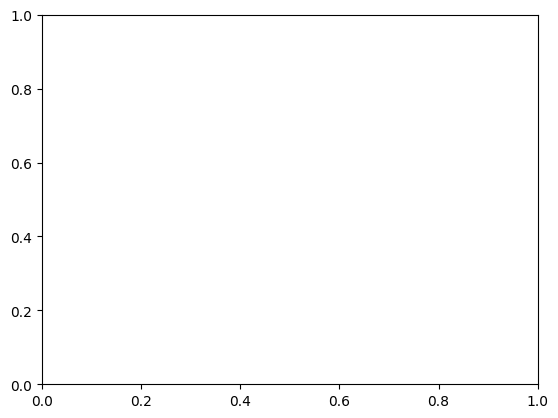

In [171]:
arr = simulate(vertices, edges, polys, parameters, T, folder)

In [163]:
#getting the center of polygons at each time step
center = []
for i in range(len(arr)):
    centertime = []
    for poly in polys:
        xc = []
        yc = []
        for v in poly.indices:
            x = arr[i][v][0]
            xc.append(x)
            y = arr[i][v][1]
            yc.append(y)
        centertime.append([np.mean(xc),np.mean(yc)])
    center.append(centertime)
center= np.array(center)
    

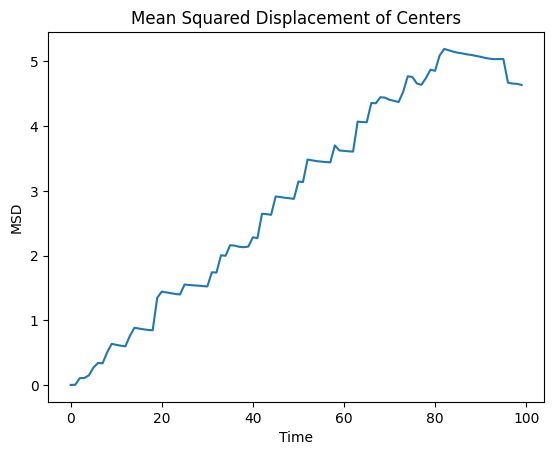

In [164]:
# plot mean squared displacement of centers
msd = []
for i in range(1,len(center)):
    rmagmeansq = []
    for j in range(len(center[i])):
        ramg = euclidean_distance(center[0,j,0],center[0,j,1],center[i,j,0],center[i,j,1])
        rmagmeansq.append(ramg**2)
    rmagmeansq = np.mean(rmagmeansq)
    msd.append(rmagmeansq)
plt.plot(msd)
#put title and axis
plt.title('Mean Squared Displacement of Centers')
plt.xlabel('Time')
plt.ylabel('MSD')
plt.show()


In [165]:
# scattering function
num_time_steps,num_particles, num_dimensions = np.shape(center)
#what should be k_values
k_values = np.array([[1,0],[1/np.sqrt(2),1/np.sqrt(2)],[0,1]])
num_wave_vectors = len(k_values)
    
intermediate_scattering_function = np.zeros((num_wave_vectors, num_time_steps)) # Initialize the array to store the intermediate scattering function values
    
for i, k in enumerate(k_values):
    for t in range(100):
        sum_cos = 0.0
        sum_sin = 0.0
                    
        for j in range(num_particles):
            r = center[t, j, :] - center[0, j, :]
            sum_cos = sum_cos + np.cos(np.dot(k, r))
            sum_sin = sum_sin + np.sin(np.dot(k, r))
                    
        intermediate_scattering_function[i, t] = (1.0 / num_particles) * (sum_cos**2 + sum_sin**2)

Text(0.5, 1.0, 'Self Intermediate Scattering function')

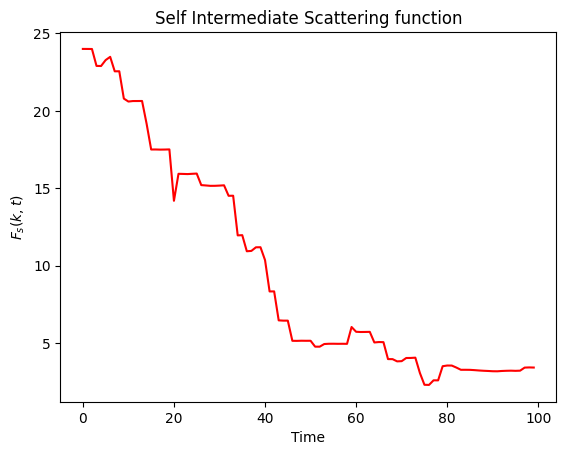

In [166]:
plt.plot(intermediate_scattering_function[1, 0:100],'-',color = 'red')
plt.ylabel('$F_s(k,t)$')
plt.xlabel('Time')
plt.title('Self Intermediate Scattering function')

# plotting ode values

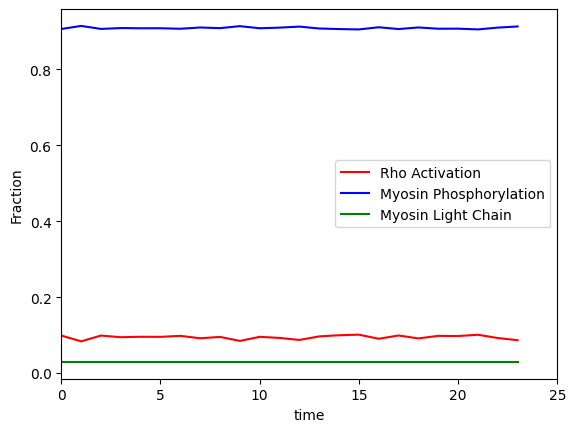

In [167]:
meanrho = []
for i in range(len(Rho[0,:])):
    meanrho.append(np.mean(Rho[:,i]))
np.array(meanrho)
plt.plot(meanrho, '-', color = 'red', label = 'Rho Activation')

# plot the mean of mp , pmlc
meanmp = []
for i in range(len(Mp[0,:])):
    meanmp.append(np.mean(Mp[:,i]))
np.array(meanmp)
plt.plot(meanmp, '-', color = 'blue', label = 'Myosin Phosphorylation')

meanpmlc = []
for i in range(len(pMLC[0,:])):
    meanpmlc.append(np.mean(pMLC[:,1]))
np.array(meanpmlc)
plt.plot(meanpmlc, '-', color = 'green', label = 'Myosin Light Chain')
plt.legend()
plt.xlabel('time')
plt.xlim(0,25)
plt.ylabel('Fraction')
plt.show()


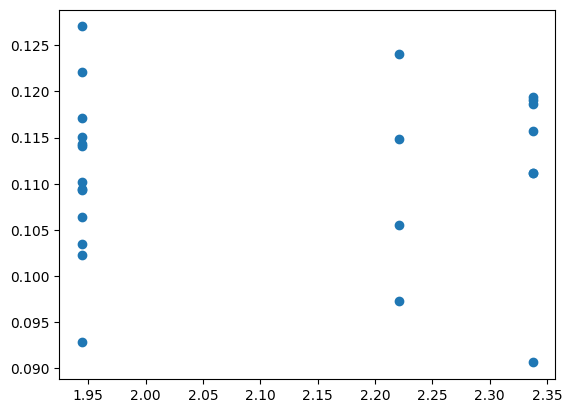

In [132]:
# plotting streatchmean vs rhomean
stretchmean = [np.mean(np.array(stretchlist2)[:,i]) for i in range(len(np.array(stretchlist2)[0,:]))]
rhomean = [np.mean(Rho[:,i]) for i in range(len(Rho[0,:]))]
plt.scatter(stretchmean, rhomean)



In [133]:
stretchlist2[:,0]

TypeError: list indices must be integers or slices, not tuple

In [ ]:
meanrho

[0.1041794500392163,
 0.08456770090415457,
 0.10304908457965452,
 0.09790649411043553,
 0.10031741054180841,
 0.10083473832634088,
 0.10333656367466924,
 0.09542752950636618,
 0.09996066969505728,
 0.0874010132300709,
 0.09989504990819231,
 0.09686812439157398,
 0.0894394742690262,
 0.10052402578139433,
 0.10182906220477389,
 0.10415367830575539,
 0.0923537941322266,
 0.10248062732410472,
 0.09351286613958247,
 0.10359404643087375,
 0.10049783819975831,
 0.10525483400951327,
 0.09319221318105074,
 0.08995597510967258]

# K_p = 0

In [ ]:
vertex_file = "data/network_vertices.txt"
edge_file = "data/edges.txt"
poly_file = "data/cell_indices.txt"
folder = "imagesnewfin2kp0"
eta = 0.1


# Parameters
lx = 9 * (2 / (3 * (3**0.5)))**0.5
ly = 4 * (2 / (3**0.5))**0.5
L = [lx,ly]
#lx = L[0]
#ly = L[1]

ka = 1.
swt = 0.

A0 = 1. # current preferred area for polygon
P0 = np.sqrt(A0)* 3.81 # current preferred perimeter for polygon
#gamma = 0.04 * ka * A0 # hexagonal network
gamma = 0.1 * ka * A0 # soft network
#Lambda = 0.12 * ka * (A0**(3/2)) # hexagonal network
# Lambda = 0
Lambda = -0.85 * ka * A0**(3/2) # soft network
lmin = 0.2
delta_t = 0.05
# eta = 0.01
xi = 0.2

# maximum Time
T = 5.

# get parameter dictionary
parameters = get_parameters(lx, ly, ka, gamma, Lambda, eta, xi, lmin, delta_t)

# get vertices
vertices = read_vertices(vertex_file)

# get edges
edges = read_edges(edge_file)

# get polygons
poly_indices = read_poly_indices(poly_file)
polys = build_polygons(poly_indices, A0, P0)


Rho = rockparam(T,delta_t)[0]
Rho[0,:] = 0.1*np.ones(len(Rho[0,:]))
Mp = rockparam(T,delta_t)[1]
Mp[0,:] = 0.1*np.ones(len(Mp[0,:]))
pMLC = rockparam(T,delta_t)[2]
pMLC[0,:] = 0.1*np.ones(len(pMLC[0,:]))

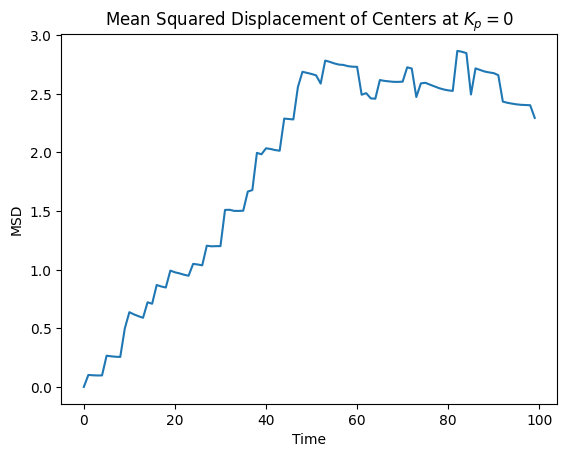

In [ ]:
arr0 = simulate(vertices, edges, polys, parameters, T, folder)

#getting the center of polygons at each time step
center0 = []
for i in range(len(arr)):
    centertime = []
    for poly in polys:
        xc = []
        yc = []
        for v in poly.indices:
            x = arr0[i][v][0]
            xc.append(x)
            y = arr0[i][v][1]
            yc.append(y)
        centertime.append([np.mean(xc),np.mean(yc)])
    center0.append(centertime)
center0= np.array(center)

msd0 = []
for i in range(1,len(center0)):
    rmagmeansq = []
    for j in range(len(center0[i])):
        ramg = euclidean_distance(center0[0,j,0],center0[0,j,1],center0[i,j,0],center0[i,j,1])
        rmagmeansq.append(ramg**2)
    rmagmeansq = np.mean(rmagmeansq)
    msd0.append(rmagmeansq)
plt.plot(msd0, '-')
#put title and axis
plt.title('Mean Squared Displacement of Centers at $K_p = 0$')
plt.xlabel('Time')
plt.ylabel('MSD')
plt.show()